In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
#train_test_split: Splits your dataset into training and testing sets

#StratifiedKFold: type of cross-validation that keeps the class distribution balanced in each fold (Since churn datasets are usually imbalanced)
#               : if 25% of customers churn in your dataset, each fold will also have ~25% churners

#GridSearchCV: Performs exhaustive search over a given parameter grid using cross-validation
#            : Performs exhaustive search over a given parameter grid using cross-validation
#            : une hyperparameters of models to maximize recall/precision on churn prediction.
#            : best practice >> Track every tried hyperparameter & result with MLflow, Save the best parameters as part of model’s metadata.

#cross_validate: Runs cross-validation and returns multiple metrics
#              : Useful to evaluate different metrics since accuracy is misleading for imbalanced data
#              : A model that predicts “No Churn” for everyone might get 75% accuracy if only 25% churn (but recall/F1 will show poor performance)
#              : best practice >> Define business-critical metric (recall for churners) Log all metrics but set recall or F1 as the key metric for model


from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, FunctionTransformer
#StandardScaler: Standardizes numerical features by removing the mean and scaling to unit variance (x - mean) / sd
#              : best practice >> fit on training data only, then transform train + test (to avoid data leakage)
#                              >> save the fitted scaler (scaler.pkl) with the model so new incoming data is scaled the same way 

#OneHotEncoder: Converts categorical variables into binary columns (0/1)

#PowerTransformer: Applies a power transform to make skewed data more Gaussian (normal distribution) ??
#                : Turns heavy-tailed distributions into a shape more suitable for ML
#                : Good for numerical features that have skewed distributions

#FunctionTransformer: Lets you wrap any custom Python function into a scikit-learn transformer
#                   : Useful for custom transformations like Create a binary feature HighCharges = MonthlyCharges > 70, Apply log scaling on TotalCharges
#                   : best practice >> keep custom transformations version-controlled (don’t hardcode in notebooks)
#                                   >> store your transformation logic in a pipeline step → ensures same logic applies in production
#                                   >> Write unit tests for custom transformers


from sklearn.compose import ColumnTransformer
#ColumnTransformer: applies different preprocessing steps to different columns of your dataset in a single pipeline
#                 : scale numerical columns, one-hot encode categorical columns, leave others untouched — all at once (dataset has mixed types)
#                 : control center that makes sure each feature is preprocessed correctly before reaching the model


from sklearn.pipeline import Pipeline
#Pipeline: chains multiple steps (preprocessing + modeling) into one unified object
#        : Steps are executed in order, and the final step must be the model
#        : avoids mistakes like applying different preprocessing at training vs inference


from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
#classification_report: Prints precision, recall, f1-score, and support (number of samples) for each class
#Precision (for churn) → Of those we predicted would churn, how many actually did?
#Recall (for churn) → Of all actual churners, how many did we catch?
#F1-score → Balance between precision & recall (important for imbalanced data).

#confusion_matrix: Table showing True Negatives, False Positives, False Negatives, True Positives.
#                : Monitor FN rate in production → if it increases, business losses rise.

#roc_auc_score: Measures the area under the ROC curve. (ROC curve plots TPR (recall) vs FPR at different thresholds)
#             : AUC = probability that the model ranks a random churner higher than a random non-churner.

#accuracy_score: (TP + TN) / Total samples.

### Cross validation importance

##### Cross-validation (CV) :is a resampling technique used to evaluate how well a model generalizes to unseen data.
##### Instead of training once and testing once, you train/test the model multiple times on different splits of the dataset.

#### Approach:
##### 1- Split data into k folds
##### 2- Train the model 1 on k-1 folds and Test on the remaining fold
##### 3- Average the results across all folds.

#### Why it matters for Churn Prediction:
##### The dataset is imbalanced
##### single train/test split may overestimate model performance.
##### Cross-validation ensures the model is evaluated on all customers at least once, reducing bias.
##### With "StratifiedKFold", each fold preserves the churn/non-churn ratio.

#### Cross-validation is like “stress-testing” your model on different slices of data to make sure it’s not just lucky on one train/test split.

In [5]:
#importing classification models

from sklearn.linear_model import LogisticRegression
#models the probability of a class (churn vs no churn) using the logistic (sigmoid) function
#Probability of churn (between 0 and 1)
#Class prediction (Yes/No churn) using a threshold (default = 0.5)

from sklearn.tree import DecisionTreeClassifier
#algorithm that splits data into branches based on feature values
#Handles mixed data (numeric + categorical after encoding).
#can visualize the tree and explain to business teams why churn happens
#Captures non-linear patterns

from sklearn.ensemble import RandomForestClassifier
#like DecisionTreeClassifier but ...
#ensemble method that builds many decision trees and combines them.
#Each tree is trained on a random subset of data + random subset of features → this reduces overfitting.
#The final prediction is usually by majority vote across trees.

import xgboost as xgb
#Instead of building many independent trees like Random Forest, XGBoost builds trees sequentially
#Outperforms Logistic Regression & Random Forest in many churn problems.
#Usually highest accuracy among ML models.
#Handles imbalance & missing values naturally.
#Provides feature importance + SHAP for interpretation.
#Can model very complex churn patterns.

from catboost import CatBoostClassifier
#a gradient boosting algorithm like XGBoost & LightGBM, but natively handles categorical features.
#No need for OneHotEncoding / LabelEncoding for categorical columns (e.g., Contract, PaymentMethod).
#Works very well on small & medium datasets (like churn).
#Often needs less hyperparameter tuning compared to XGBoost.

#### hyperparameter tuning

In [7]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Dataset discribtion

| Column               | Type                                               | Description                                                                               |
| -------------------- | -------------------------------------------------- | ----------------------------------------------------------------------------------------- |
| **customerID**       | Categorical (ID)                                   | Unique identifier for each customer.                                                      |
| **gender**           | Categorical (Male/Female)                          | Gender of the customer.                                                                   |
| **SeniorCitizen**    | Numerical (0/1)                                    | Whether the customer is a senior citizen (1 = Yes, 0 = No).                               |
| **Partner**          | Categorical (Yes/No)                               | Whether the customer has a partner.                                                       |
| **Dependents**       | Categorical (Yes/No)                               | Whether the customer has dependents (children, family, etc.).                             |
| **tenure**           | Numerical                                          | Number of months the customer has stayed with the company.                                |
| **PhoneService**     | Categorical (Yes/No)                               | Whether the customer has a phone service.                                                 |
| **MultipleLines**    | Categorical (Yes/No/No phone service)              | If they have multiple phone lines.                                                        |
| **InternetService**  | Categorical (DSL/Fiber optic/No)                   | Type of internet service the customer has.                                                |
| **OnlineSecurity**   | Categorical (Yes/No/No internet service)           | Whether the customer has online security service.                                         |
| **OnlineBackup**     | Categorical (Yes/No/No internet service)           | Whether the customer has online backup service.                                           |
| **DeviceProtection** | Categorical (Yes/No/No internet service)           | Whether the customer has device protection plan.                                          |
| **TechSupport**      | Categorical (Yes/No/No internet service)           | Whether the customer has tech support service.                                            |
| **StreamingTV**      | Categorical (Yes/No/No internet service)           | Whether the customer streams TV.                                                          |
| **StreamingMovies**  | Categorical (Yes/No/No internet service)           | Whether the customer streams movies.                                                      |
| **Contract**         | Categorical (Month-to-month / One year / Two year) | Type of contract the customer has.                                                        |
| **PaperlessBilling** | Categorical (Yes/No)                               | Whether they use paperless billing.                                                       |
| **PaymentMethod**    | Categorical                                        | How the customer pays (e.g., Electronic check, Mailed check, Bank transfer, Credit card). |
| **MonthlyCharges**   | Numerical                                          | Amount charged to the customer monthly.                                                   |
| **TotalCharges**     | Numerical                                          | Total amount charged over the tenure.                                                     |
| **Churn**            | Target (Yes/No)                                    | Whether the customer churned (Yes = left, No = stayed).                                   |


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


##### no null values 

In [12]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


### EDA

In [14]:
cat_features = df.select_dtypes(include=["object"]).columns.tolist()

cat_features

['customerID',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'TotalCharges',
 'Churn']

In [15]:
num_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

num_features

['SeniorCitizen', 'tenure', 'MonthlyCharges']

In [16]:
for cat in cat_features:
    print(cat)
    print(f"{df[cat].nunique()} unique values")
    print(df[cat].unique())
    print("\n")

customerID
7043 unique values
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']


gender
2 unique values
['Female' 'Male']


Partner
2 unique values
['Yes' 'No']


Dependents
2 unique values
['No' 'Yes']


PhoneService
2 unique values
['No' 'Yes']


MultipleLines
3 unique values
['No phone service' 'No' 'Yes']


InternetService
3 unique values
['DSL' 'Fiber optic' 'No']


OnlineSecurity
3 unique values
['No' 'Yes' 'No internet service']


OnlineBackup
3 unique values
['Yes' 'No' 'No internet service']


DeviceProtection
3 unique values
['No' 'Yes' 'No internet service']


TechSupport
3 unique values
['No' 'Yes' 'No internet service']


StreamingTV
3 unique values
['No' 'Yes' 'No internet service']


StreamingMovies
3 unique values
['No' 'Yes' 'No internet service']


Contract
3 unique values
['Month-to-month' 'One year' 'Two year']


PaperlessBilling
2 unique values
['Yes' 'No']


PaymentMethod
4 unique values
['Electronic check' 'Mailed check' 'Bank 

##### total charges is numeric feature

In [18]:
for n in num_features:
    print(n)
    print(f"{df[n].nunique()} unique values")
    print(df[n].unique())
    print("\n")

SeniorCitizen
2 unique values
[0 1]


tenure
73 unique values
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]


MonthlyCharges
1585 unique values
[29.85 56.95 53.85 ... 63.1  44.2  78.7 ]




##### here senior citizen is a categorical feature

In [20]:
cat_features.remove("TotalCharges")
num_features.append("TotalCharges")

num_features.remove("SeniorCitizen")
cat_features.append("SeniorCitizen")

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce") #errors="coerce": forcing errors to NaN
print(f"Nulls in TotalCharges equals {df["TotalCharges"].isna().sum()}")

Nulls in TotalCharges equals 11


In [21]:
df[df["TotalCharges"].isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


##### They seems to be new customer 

In [23]:
df[(df["TotalCharges"].isna()) & (df["tenure"] == 0)].shape[0]

11

##### All the 11 rows have tenure = 0 (less than month) then they are new customers 
##### so i will replace total charges by 0

In [25]:
df["TotalCharges"] = df["TotalCharges"].fillna(0)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [27]:
cat_features

['customerID',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn',
 'SeniorCitizen']

In [28]:
num_features

['tenure', 'MonthlyCharges', 'TotalCharges']

### Churn distribution

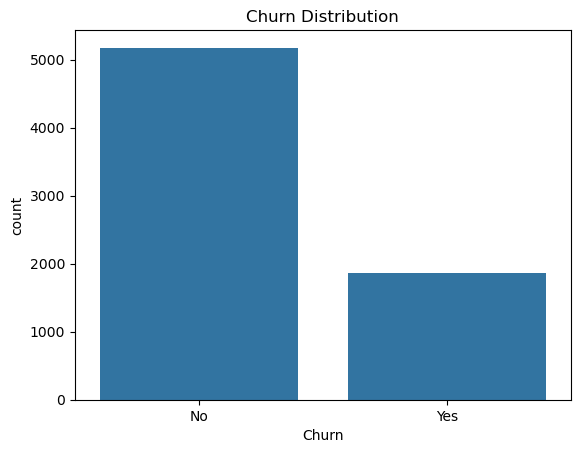

In [30]:
sns.countplot(data=df, x="Churn")
plt.title("Churn Distribution");

In [31]:
churn_rate = df["Churn"].value_counts(normalize=True) #normalize=True: get the percentage
print(churn_rate)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


##### there is a huge imbalance in the dataset where the number of not churned customers are high than the number of churned customers

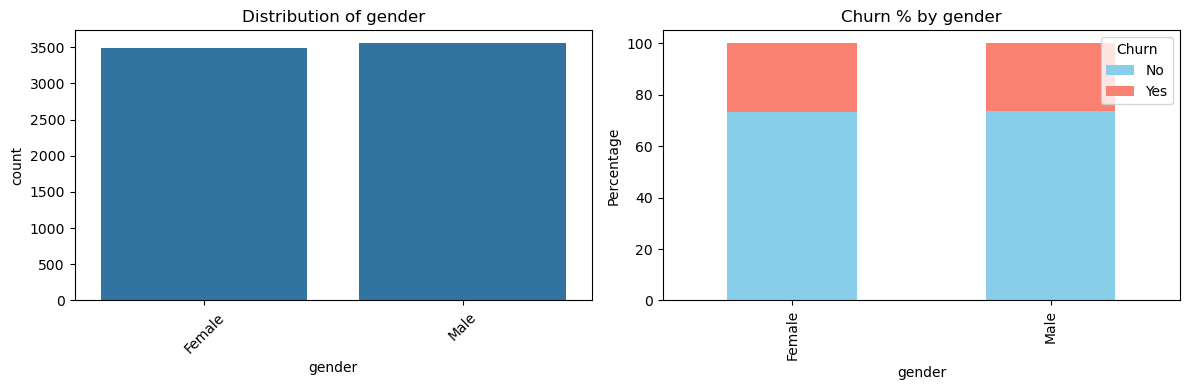

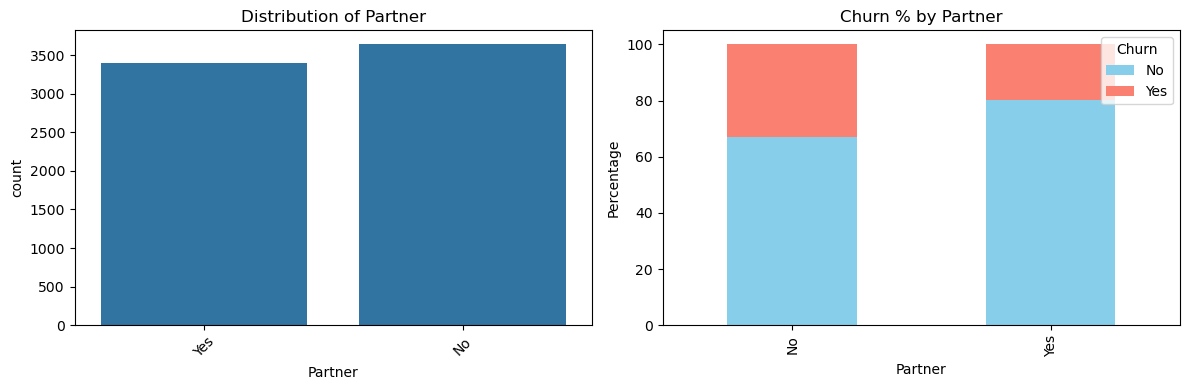

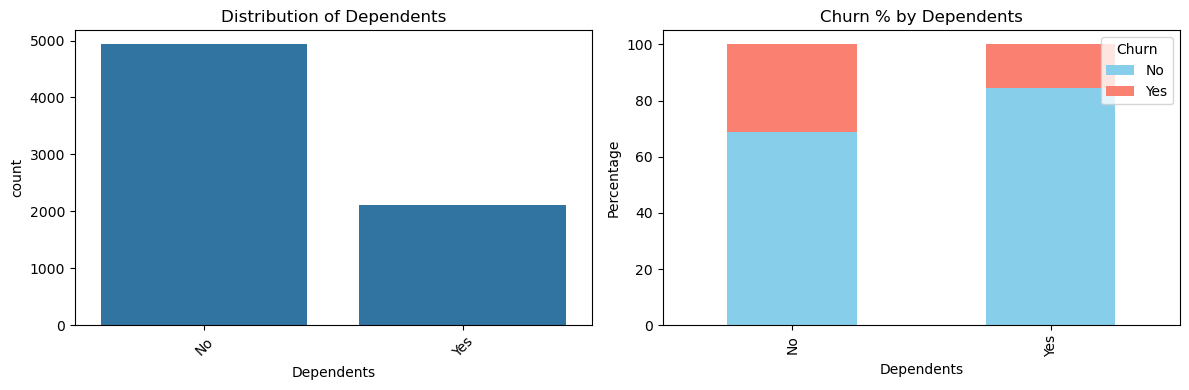

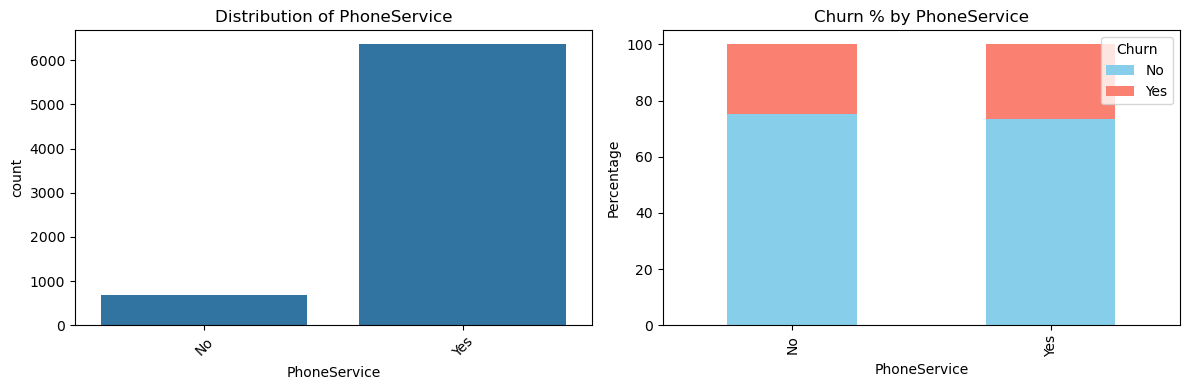

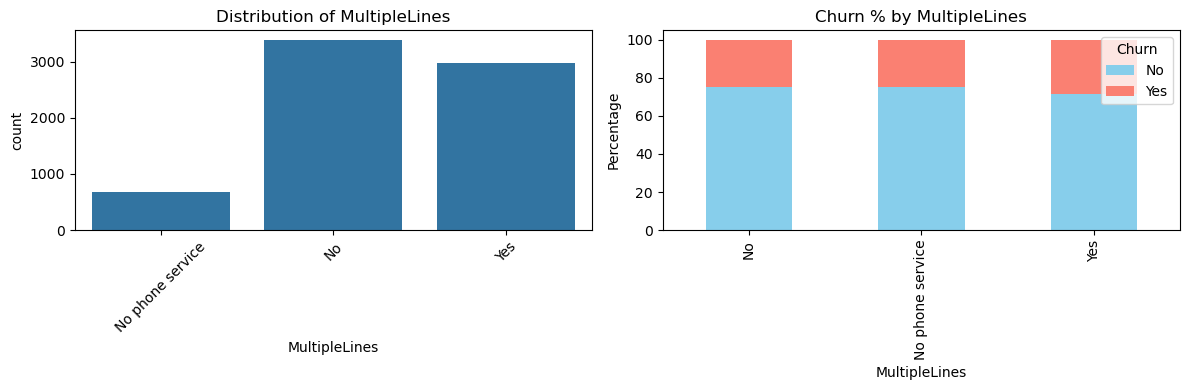

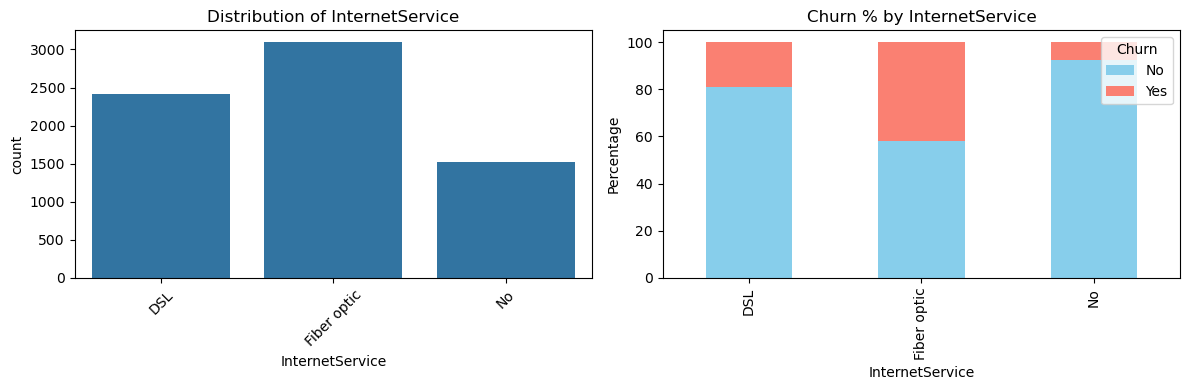

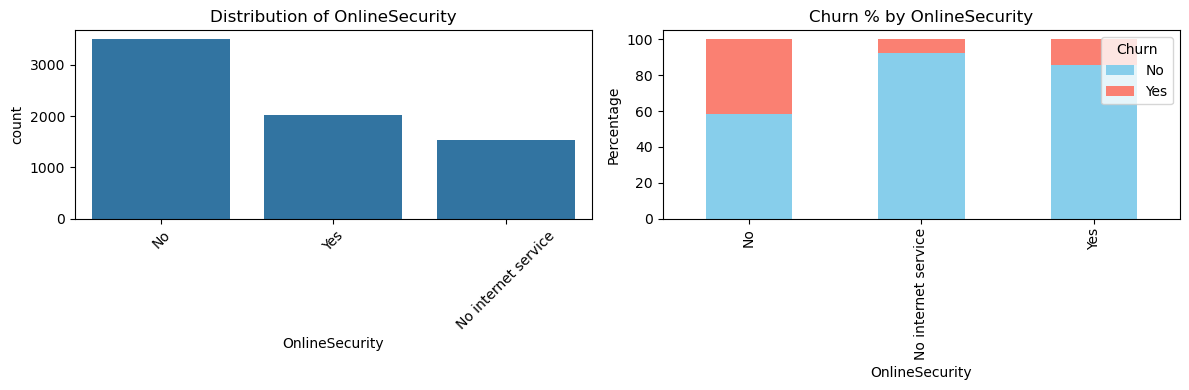

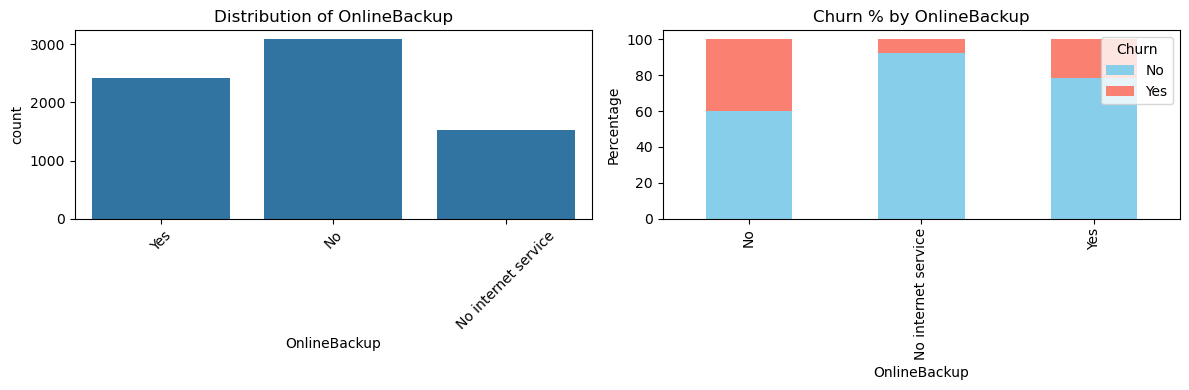

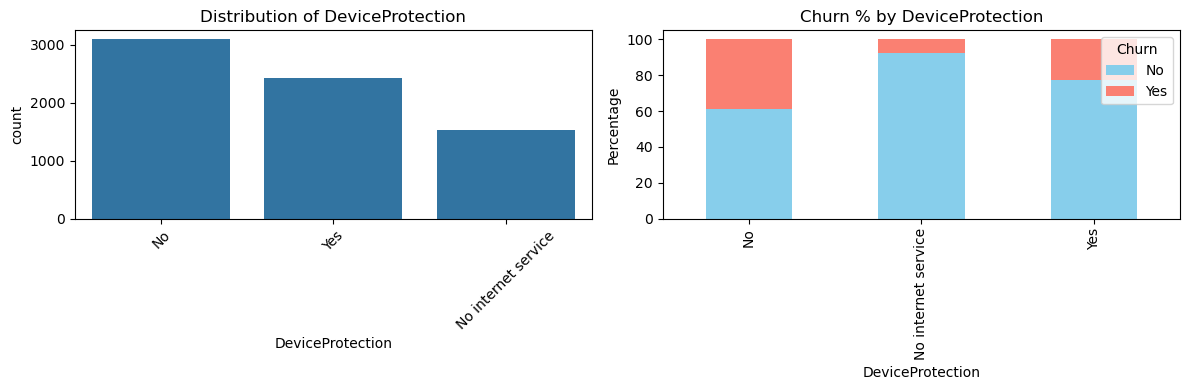

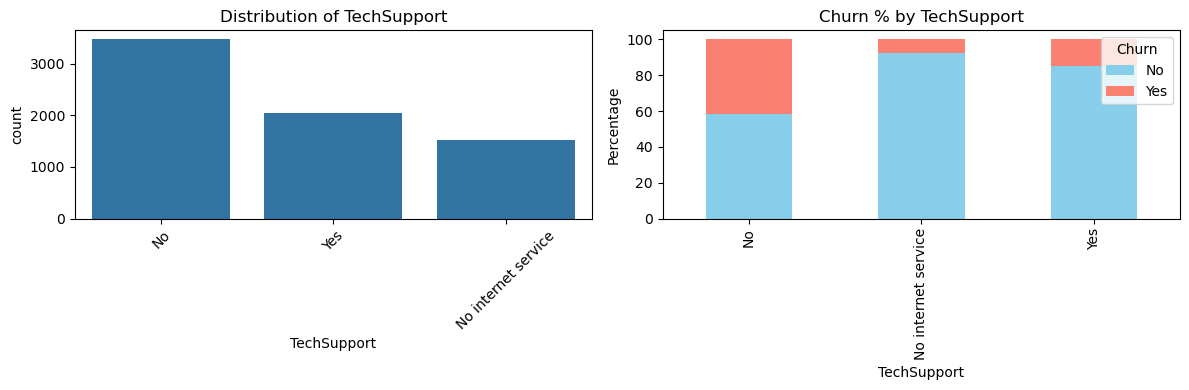

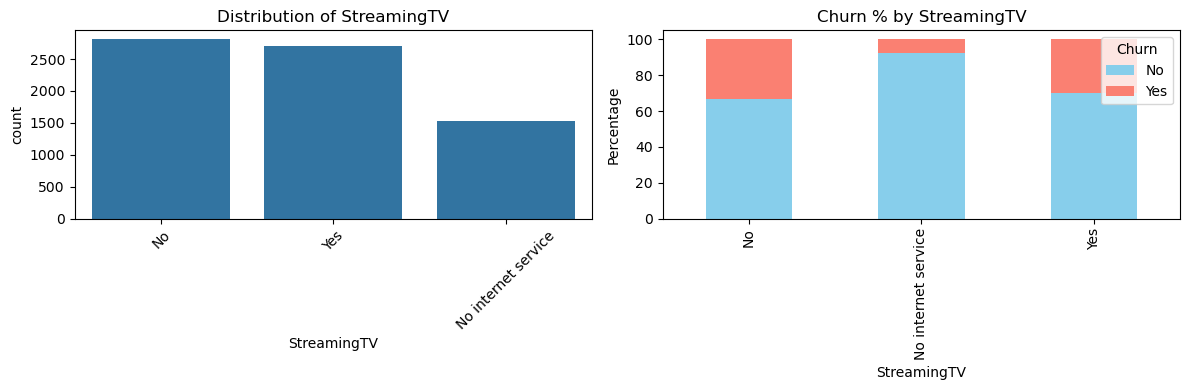

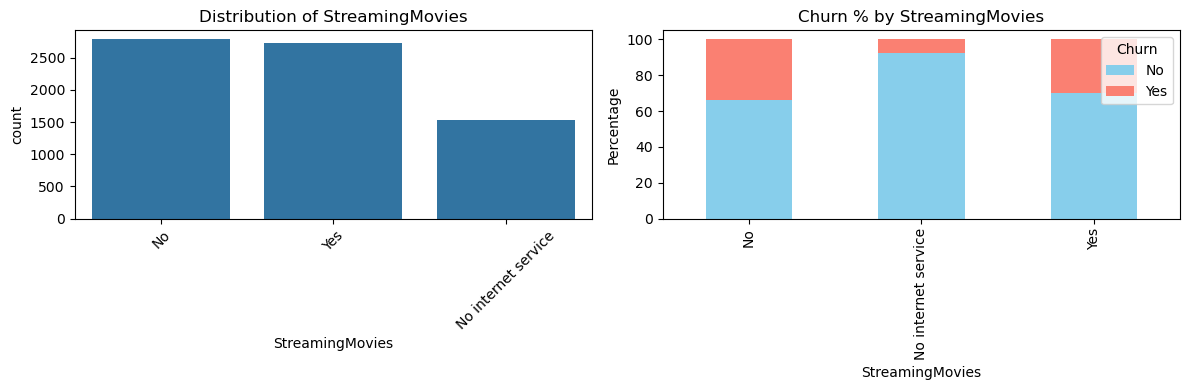

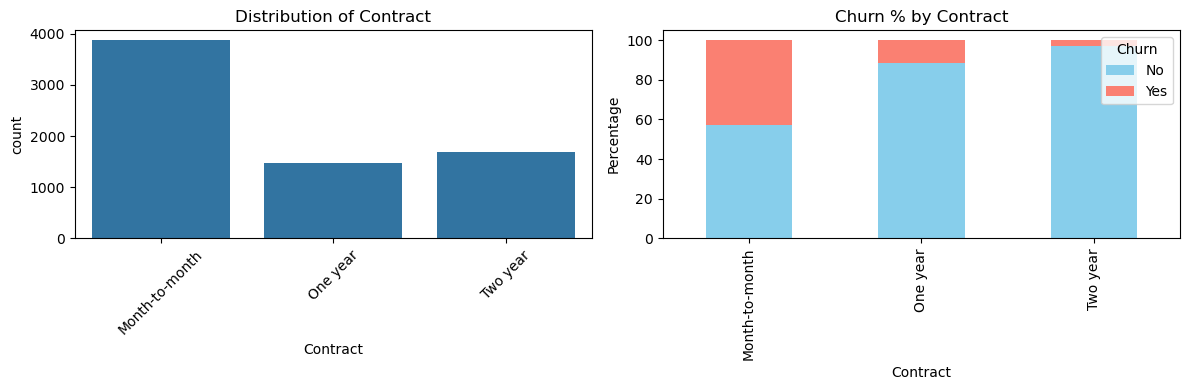

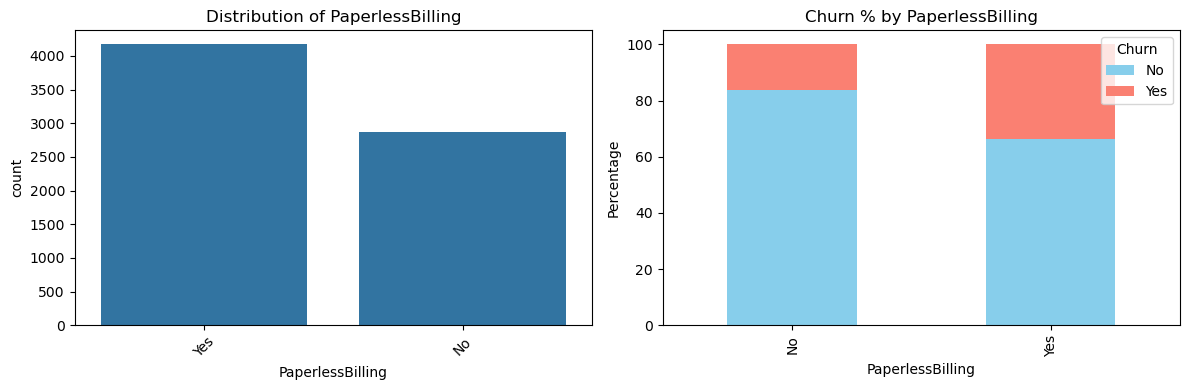

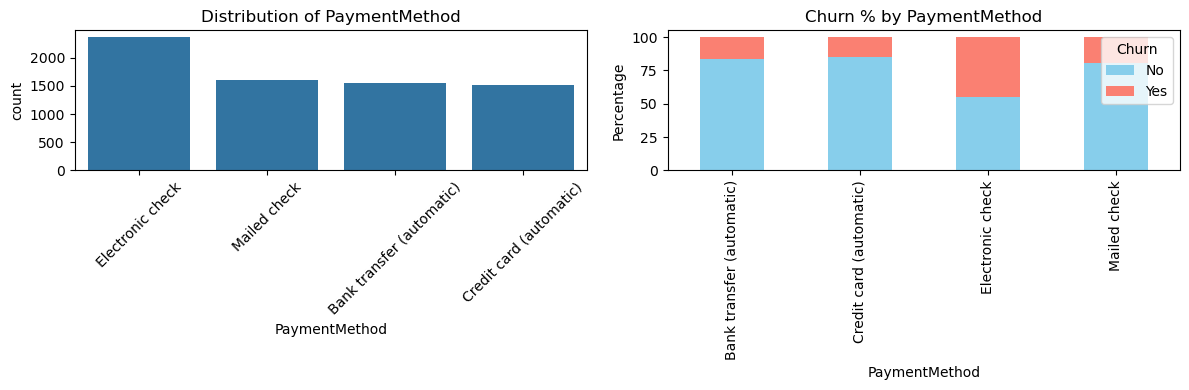

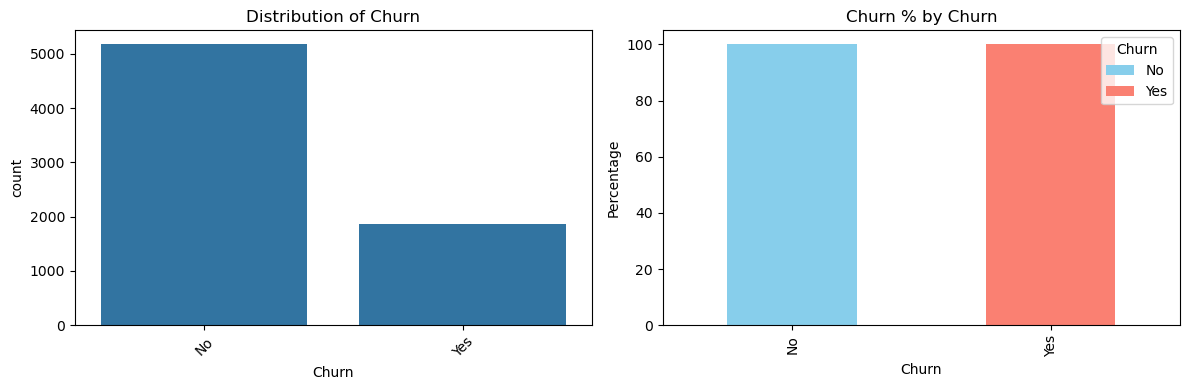

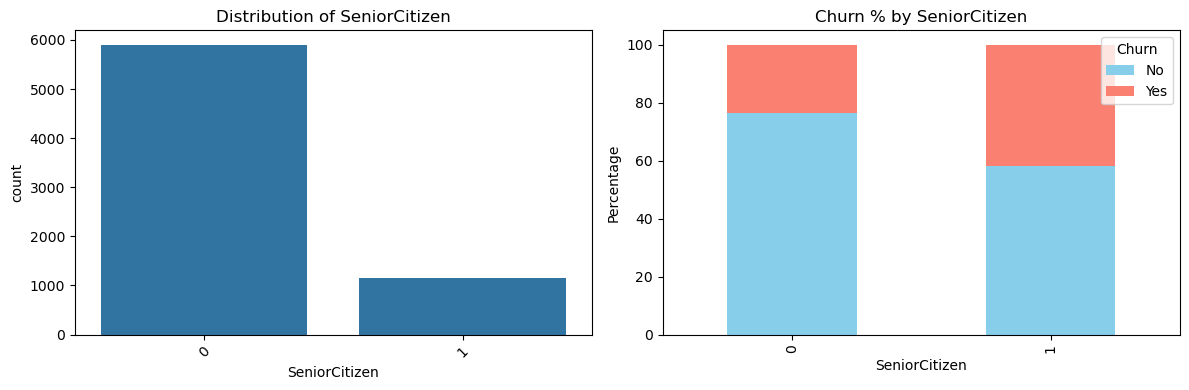

In [33]:
cat_features.remove("customerID")
for col in cat_features:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    # Left: Distribution of feature
    sns.countplot(x=col, data=df, ax=axes[0])
    axes[0].set_title(f"Distribution of {col}")
    axes[0].tick_params(axis='x', rotation=45)

    # Right: Feature vs Churn
    churn_dist = pd.crosstab(df[col], df['Churn'], normalize='index') * 100 #pd.crosstab: creates a table showing churn distribution per category
    churn_dist.plot(kind='bar', stacked=True, color=['skyblue','salmon'], ax=axes[1])
    axes[1].set_title(f"Churn % by {col}")
    axes[1].set_ylabel("Percentage")
    axes[1].legend(title="Churn")
    axes[1].legend(title="Churn", loc="upper right")

    plt.tight_layout()
    plt.show()

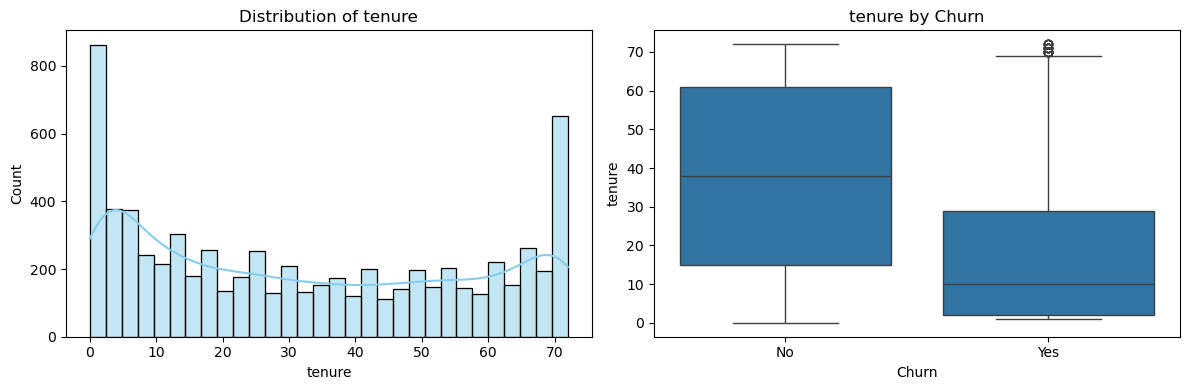

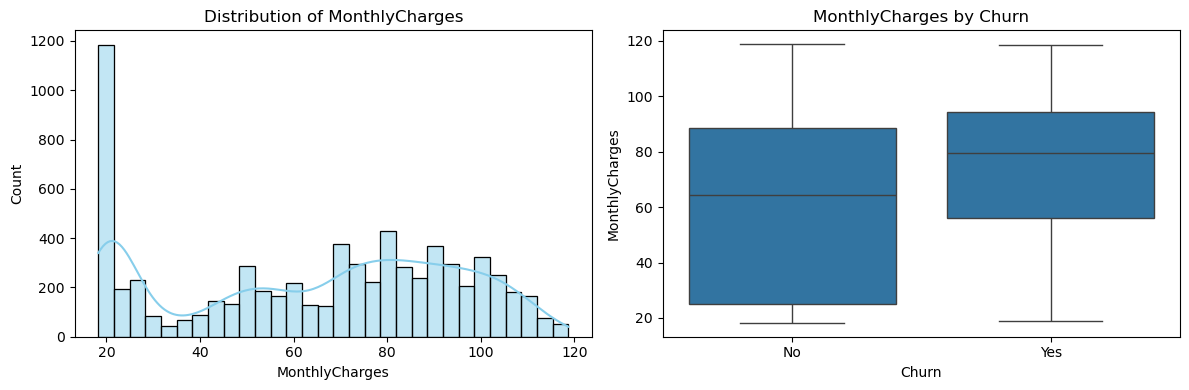

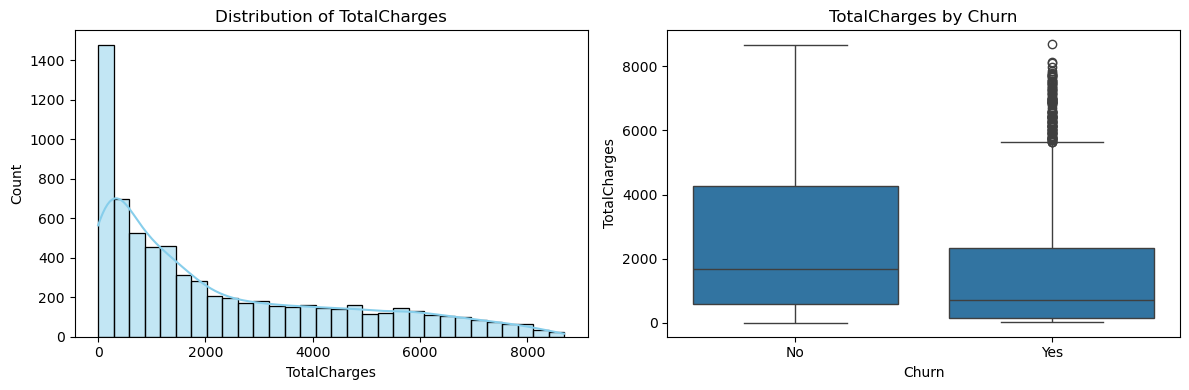

In [34]:
for col in num_features:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    # Left: Distribution (histogram)
    sns.histplot(df[col], bins=30, kde=True, ax=axes[0], color="skyblue")
    axes[0].set_title(f"Distribution of {col}")

    # Right: Boxplot vs Churn
    sns.boxplot(x="Churn", y=col, data=df, ax=axes[1])
    axes[1].set_title(f"{col} by Churn")

    plt.tight_layout()
    plt.show()

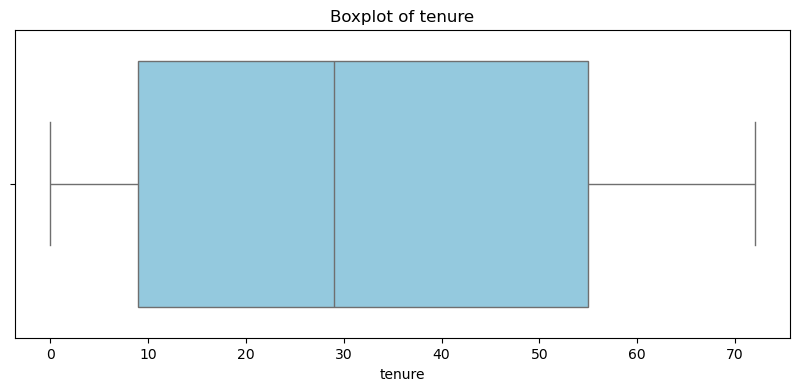

tenure: 0 outliers detected
Lower bound: -60.0, Upper bound: 124.0



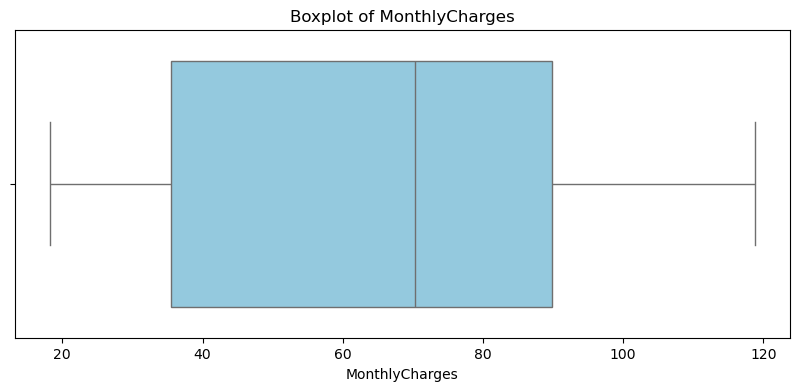

MonthlyCharges: 0 outliers detected
Lower bound: -46.02499999999999, Upper bound: 171.375



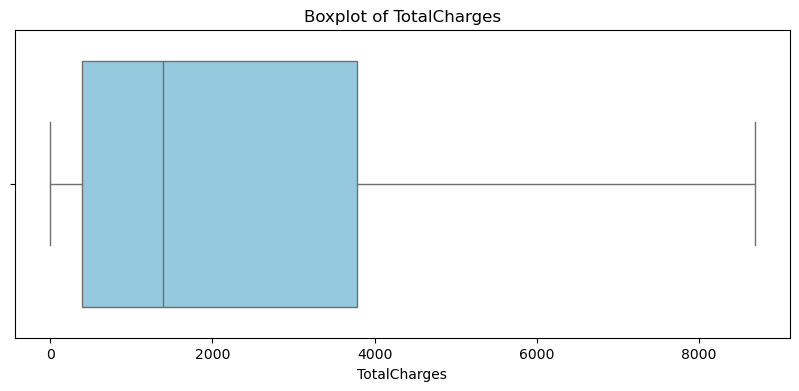

TotalCharges: 0 outliers detected
Lower bound: -4683.525, Upper bound: 8868.675



In [35]:
for col in num_features:
    plt.figure(figsize=(10,4))

    # Boxplot
    sns.boxplot(x=df[col], color="skyblue")
    plt.title(f"Boxplot of {col}")
    plt.show()

    # IQR Calculation
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {outliers.shape[0]} outliers detected")
    print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}\n")

### Feature Engineering

#### Tenture_category
###### New: 0-1 year
###### Established: 1-4 years
###### Loyal: 4-6 years

In [38]:
def tenure_category(tenure):
    if tenure <= 12: 
        return "New"          # 0–1 year
    elif tenure <= 48: 
        return "Established"  # 1–4 years
    else: 
        return "Loyal"        # 4–6 years

df["Tenure_category"] = df["tenure"].apply(tenure_category)

In [39]:
df["Charge_category"] = pd.qcut(df["MonthlyCharges"], q=3, labels=["Low","Medium","High"])

In [40]:
service_cols = ['PhoneService','MultipleLines','InternetService',
                'OnlineSecurity','OnlineBackup','DeviceProtection',
                'TechSupport','StreamingTV','StreamingMovies']

for s in service_cols:
    print(df[s].unique())

['No' 'Yes']
['No phone service' 'No' 'Yes']
['DSL' 'Fiber optic' 'No']
['No' 'Yes' 'No internet service']
['Yes' 'No' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']


In [41]:
yes_no_cols = ['PhoneService','MultipleLines',
                'OnlineSecurity','OnlineBackup','DeviceProtection',
                'TechSupport','StreamingTV','StreamingMovies']

has_internet = (df["InternetService"] != "No").astype(int)

add_ons = (df[yes_no_cols] == "Yes").sum(axis=1)

df["Service_count"] = has_internet + add_ons

In [42]:
df["Bundle_user"] = np.where(
    (df["InternetService"] != "No") & (df["PhoneService"] == "Yes"), 1, 0
)

### Transforming Strategy

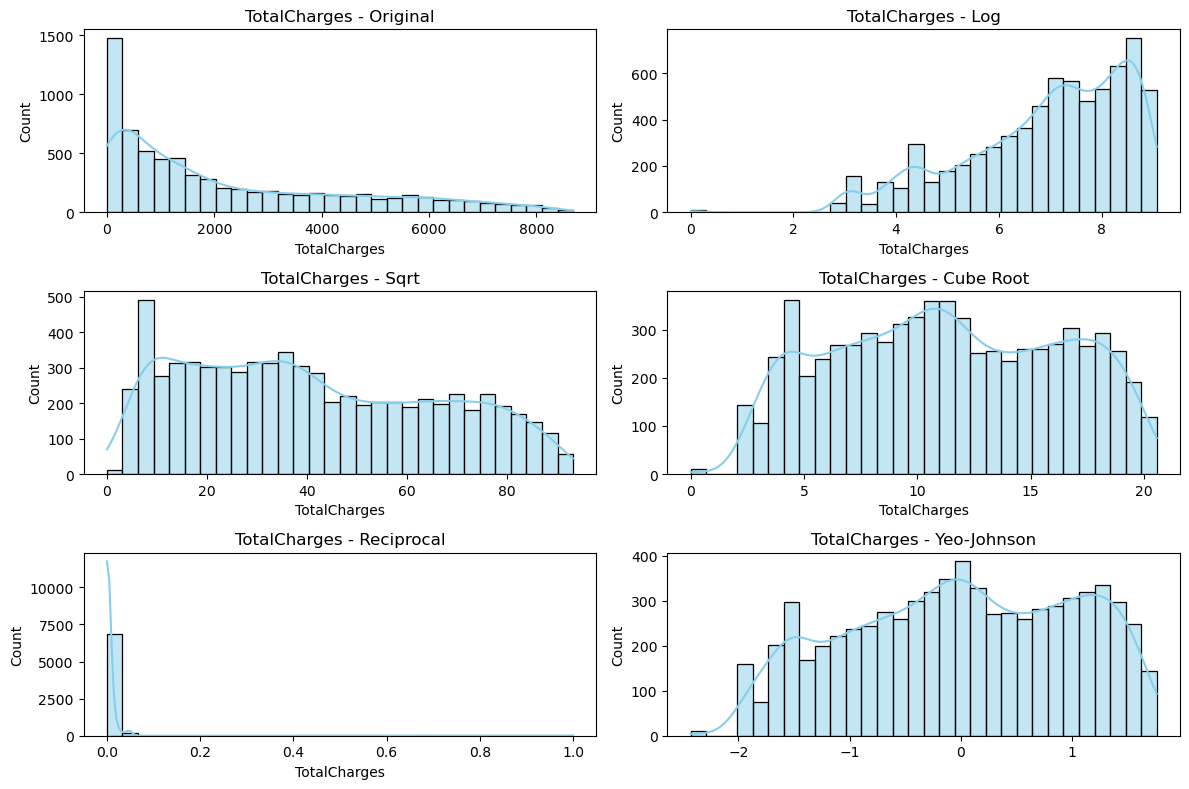

In [44]:
feature = "TotalCharges"
x = df[feature].copy()

# Transformations
transforms = {
    "Original": x,
    "Log": np.log1p(x),
    "Sqrt": np.sqrt(x),
    "Cube Root": np.cbrt(x),
    "Reciprocal": 1/(x+1),  # +1 to avoid division by zero
    "Yeo-Johnson": PowerTransformer(method="yeo-johnson").fit_transform(x.values.reshape(-1,1)).flatten()
}

# Plot results
plt.figure(figsize=(12,8))
for i, (name, vals) in enumerate(transforms.items(), 1): #1 "the last parameter"  to start from 1 not 0 "bec i used in subplot"
    plt.subplot(3,2,i)
    sns.histplot(vals, bins=30, kde=True, color="skyblue")
    plt.title(f"{feature} - {name}")
plt.tight_layout()
plt.show()

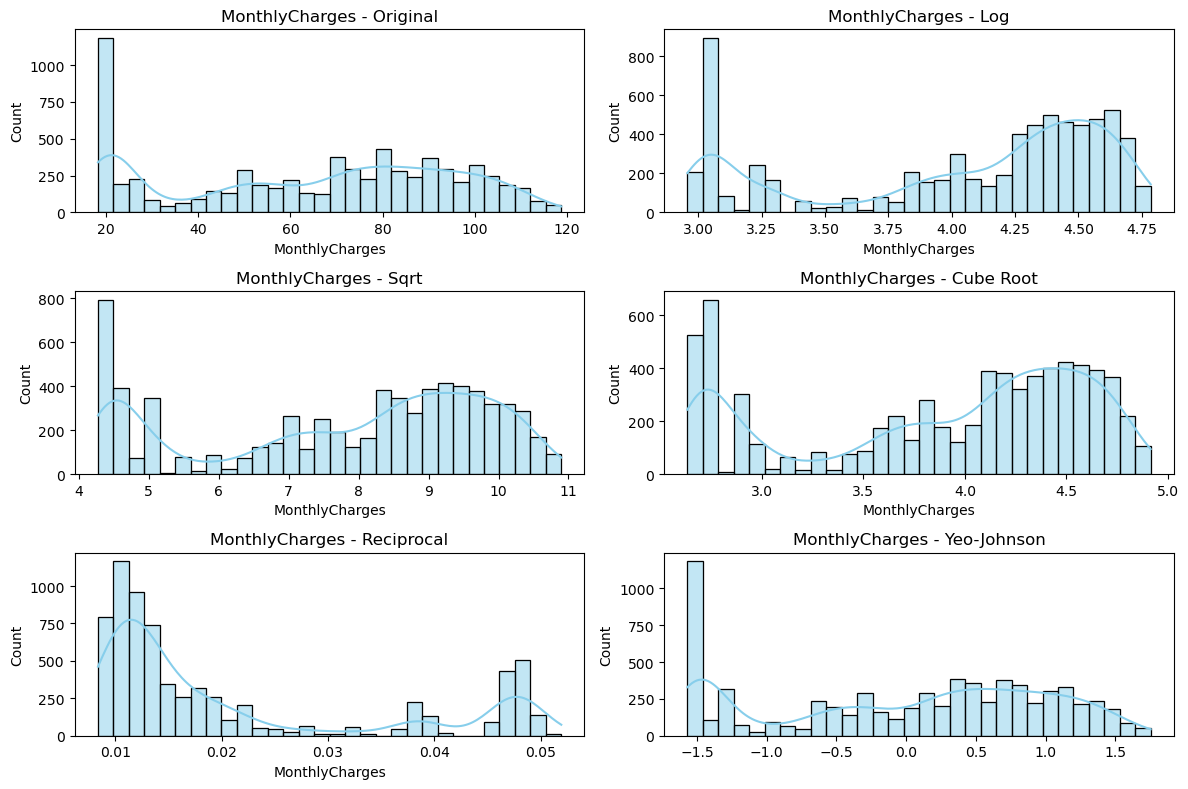

In [45]:
feature = "MonthlyCharges"
x = df[feature].copy()

# Transformations
transforms = {
    "Original": x,
    "Log": np.log1p(x),
    "Sqrt": np.sqrt(x),
    "Cube Root": np.cbrt(x),
    "Reciprocal": 1/(x+1),  # +1 to avoid division by zero
    "Yeo-Johnson": PowerTransformer(method="yeo-johnson").fit_transform(x.values.reshape(-1,1)).flatten()
}

# Plot results
plt.figure(figsize=(12,8))
for i, (name, vals) in enumerate(transforms.items(), 1):
    plt.subplot(3,2,i)
    sns.histplot(vals, bins=30, kde=True, color="skyblue")
    plt.title(f"{feature} - {name}")
plt.tight_layout()
plt.show()

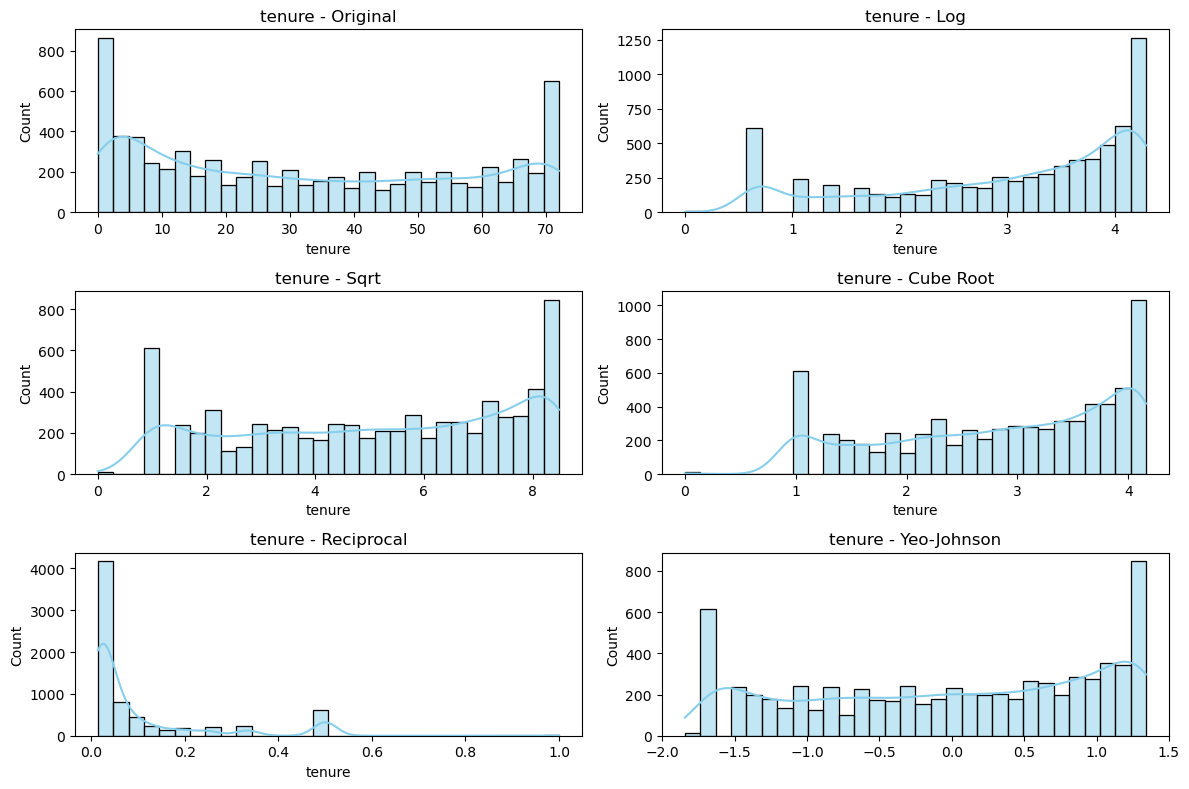

In [46]:
feature = "tenure"
x = df[feature].copy()

# Transformations
transforms = {
    "Original": x,
    "Log": np.log1p(x),
    "Sqrt": np.sqrt(x),
    "Cube Root": np.cbrt(x),
    "Reciprocal": 1/(x+1),  # +1 to avoid division by zero
    "Yeo-Johnson": PowerTransformer(method="yeo-johnson").fit_transform(x.values.reshape(-1,1)).flatten()
}

# Plot results
plt.figure(figsize=(12,8))
for i, (name, vals) in enumerate(transforms.items(), 1):
    plt.subplot(3,2,i)
    sns.histplot(vals, bins=30, kde=True, color="skyblue")
    plt.title(f"{feature} - {name}")
plt.tight_layout()
plt.show()

#### Choosed transformations:
###### TotalCharges >> Square root
###### MonthlyCharges >> No need to transform because each graph looks like the same
###### tenture >> No need to transform the original ones seems the best

In [48]:
cat_features.extend(["Charge_category", "Tenure_category","Bundle_user"])
num_features.append("Service_count")

cat_features

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn',
 'SeniorCitizen',
 'Charge_category',
 'Tenure_category',
 'Bundle_user']

In [49]:
X = df.drop(["Churn"], axis = 1)
y = df["Churn"].map({"Yes":1,"No":0})

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

customer_id = X_test["customerID"].copy()

X_train = X_train.drop("customerID", axis=1)
X_test = X_test.drop("customerID", axis=1)

X_train.shape

(5634, 23)

### Data Preprocessing Pipeline¶

#### Apply sqrt to the selected column

In [52]:
sqrt_obj = FunctionTransformer(np.sqrt,validate = True) # validate=True → ensures the input is 2D (array-like)
           # FunctionTransformer: lets you wrap any function into a scikit-learn transformer so it can be used inside a pipeline.
sqrt_features = ['TotalCharges']

sqrt_transformer = ColumnTransformer(
    transformers=[
        ('sqrt',sqrt_obj,sqrt_features), #...., if there is another
    ],
    remainder = 'passthrough'
)

#ColumnTransformer allows you to apply different transformations to different columns.
#Inside transformers=[...] you define a list of rules:
#'sqrt' → just a name for this transformer.
#sqrt_obj → the transformer we defined earlier.
#sqrt_features → the list of columns (["TotalCharges"]) it should apply to.
#remainder='passthrough' → all other columns are left unchanged (they "pass through").

#### Scaling & normalization to all numeric columns

In [54]:
numeric_pipeline = Pipeline(
    steps=[
        ('sqrt_transform',sqrt_transformer),
        ('scaler',StandardScaler()),
    ]
)

#### Define objects for categorical columns

In [56]:
cat_features = [col for col in cat_features if col != "Churn"]
norminal_encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)

#### entire preprocessing pipeline

In [58]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num',numeric_pipeline,num_features),
        ('cat',norminal_encoder,cat_features)
    ]
)

### Model Building Pipeline

In [106]:
n_positive = sum(y_train == 1)  
n_negative = sum(y_train == 0)  

scale_pos_weight = n_negative / n_positive

scale_pos_weight

2.768561872909699

In [108]:
models = {
    "Logistic Regression": LogisticRegression(max_iter = 100, class_weight = 'balanced'),
    #max_iter=100: ensures enough iterations for convergence, class_weight='balanced': automatically adjusts weights for imbalanced data.
    "Decision Tree": DecisionTreeClassifier(class_weight = 'balanced'),
    "Random Forest": RandomForestClassifier(n_estimators= 100,class_weight='balanced'),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss',scale_pos_weight = (n_negative / n_positive)),
    # scale_pos_weight: very important for imbalanced datasets, Tells the model to pay more attention to the minority class.
    "CatBoost":CatBoostClassifier(verbose=0,auto_class_weights='Balanced')
    #verbose=0: hides training logs, auto_class_weights='Balanced': automatically handles class imbalance.
}

#### Cross validation
##### ensures that each fold has the same proportion of classes as the original dataset, bec. data is imbalanced

In [113]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

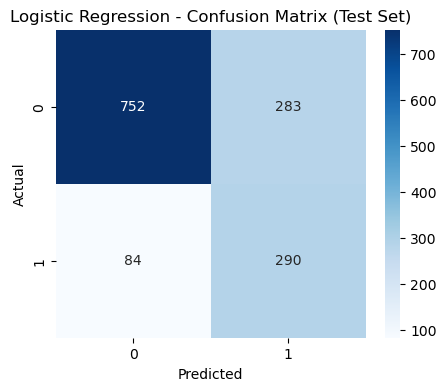


===== Logistic Regression =====
Training Accuracy : 0.754 | ROC-AUC : 0.851
Test Accuracy     : 0.740 | ROC-AUC : 0.841
Cross-Validation Accuracy : 0.751 ± 0.015
Cross-Validation ROC-AUC  : 0.847 ± 0.011
              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1035
           1       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



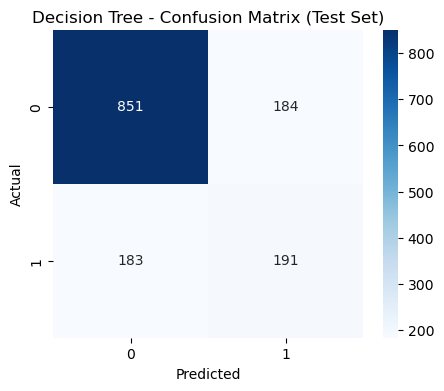


===== Decision Tree =====
Training Accuracy : 0.998 | ROC-AUC : 1.000
Test Accuracy     : 0.740 | ROC-AUC : 0.667
Cross-Validation Accuracy : 0.742 ± 0.010
Cross-Validation ROC-AUC  : 0.666 ± 0.015
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1035
           1       0.51      0.51      0.51       374

    accuracy                           0.74      1409
   macro avg       0.67      0.67      0.67      1409
weighted avg       0.74      0.74      0.74      1409



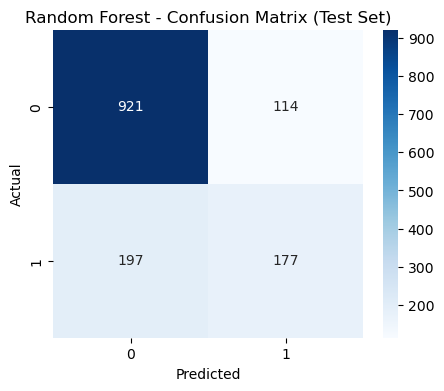


===== Random Forest =====
Training Accuracy : 0.998 | ROC-AUC : 1.000
Test Accuracy     : 0.779 | ROC-AUC : 0.819
Cross-Validation Accuracy : 0.789 ± 0.011
Cross-Validation ROC-AUC  : 0.822 ± 0.011
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1035
           1       0.61      0.47      0.53       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409



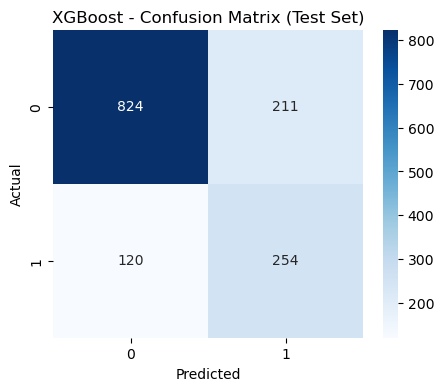


===== XGBoost =====
Training Accuracy : 0.928 | ROC-AUC : 0.989
Test Accuracy     : 0.765 | ROC-AUC : 0.823
Cross-Validation Accuracy : 0.769 ± 0.011
Cross-Validation ROC-AUC  : 0.825 ± 0.008
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1035
           1       0.55      0.68      0.61       374

    accuracy                           0.77      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.77      0.77      1409



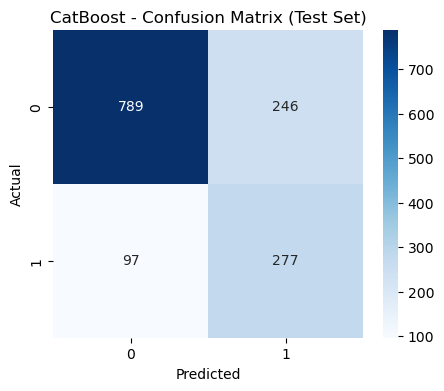


===== CatBoost =====
Training Accuracy : 0.855 | ROC-AUC : 0.941
Test Accuracy     : 0.757 | ROC-AUC : 0.838
Cross-Validation Accuracy : 0.766 ± 0.008
Cross-Validation ROC-AUC  : 0.841 ± 0.009
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1035
           1       0.53      0.74      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409



In [115]:
results = {}

for name, model in models.items():
    clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])
    
    # --- Cross-validation on training data ---
    cv_scores = cross_validate(
        clf, X_train, y_train, cv=cv,
        scoring=["accuracy", "roc_auc"], return_train_score=True
    )
    
    # --- Fit on full training set ---
    clf.fit(X_train, y_train)
    
    # --- Predictions for training and test sets ---
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    y_train_proba = clf.predict_proba(X_train)[:,1]
    y_test_proba = clf.predict_proba(X_test)[:,1]
    
    # --- Metrics ---
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_auc = roc_auc_score(y_train, y_train_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)

    # --- Confusion matrix (test set) ---
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
    plt.title(f"{name} - Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    # --- Print metrics ---
    print(f"\n===== {name} =====")
    print(f"Training Accuracy : {train_acc:.3f} | ROC-AUC : {train_auc:.3f}")
    print(f"Test Accuracy     : {test_acc:.3f} | ROC-AUC : {test_auc:.3f}")
    print(f"Cross-Validation Accuracy : {cv_scores['test_accuracy'].mean():.3f} ± {cv_scores['test_accuracy'].std():.3f}")
    print(f"Cross-Validation ROC-AUC  : {cv_scores['test_roc_auc'].mean():.3f} ± {cv_scores['test_roc_auc'].std():.3f}")
    print(classification_report(y_test, y_test_pred))

    # --- Save results ---
    results[name] = {
        "train_accuracy": train_acc,
        "train_roc_auc": train_auc,
        "test_accuracy": test_acc,
        "test_roc_auc": test_auc,
        "cv_accuracy_mean": cv_scores['test_accuracy'].mean(),
        "cv_accuracy_std": cv_scores['test_accuracy'].std(),
        "cv_roc_auc_mean": cv_scores['test_roc_auc'].mean(),
        "cv_roc_auc_std": cv_scores['test_roc_auc'].std(),
        "confusion_matrix": cm
    }

### Hyperparameter tuning¶


In [118]:
# Pipeline: preprocessing + model
clf_new = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

# Hyperparameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs']
}

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    clf_new, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1
)

# Fit
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV ROC-AUC:", grid_search.best_score_)

Best parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best CV ROC-AUC: 0.8468346266973871


In [120]:
final_model = grid_search.best_estimator_
final_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('sqrt_transform',
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('sqrt',
                                                                                                    FunctionTransformer(func=<ufunc 'sqrt'>,
                                                                                                                        validate=True),
                                                                                                    ['TotalCharges'])])),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'Service_count']),
                                                 ('cat',
                                                  OneHotEnc...
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'SeniorCitizen',
                                                   'Charge_category',
                                                   'Tenure_category',
                                                   'Bundle_user'])])),
                ('classifier', LogisticRegression(C=0.1, max_iter=1000))])

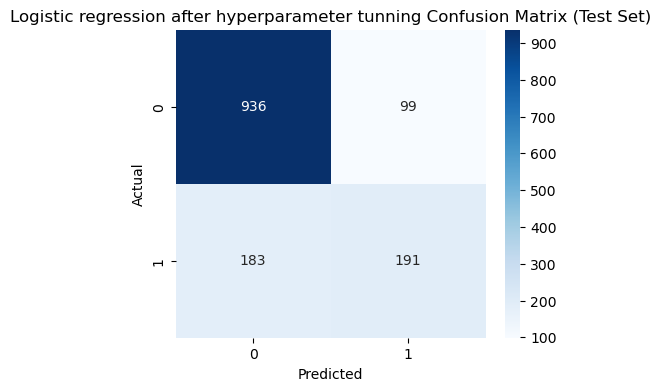


===== Logistic regression after hyperparameter tunning=====
Training Accuracy : 0.811 | ROC-AUC : 0.851
Test Accuracy     : 0.800 | ROC-AUC : 0.842
Cross-Validation Accuracy : 0.766 ± 0.008
Cross-Validation ROC-AUC  : 0.841 ± 0.009
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.51      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



In [125]:
# --- Fit on full training set ---
final_model.fit(X_train, y_train)

# --- Predictions for training and test sets ---
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

y_train_proba = final_model.predict_proba(X_train)[:,1]
y_test_proba = final_model.predict_proba(X_test)[:,1]

# --- Metrics ---
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

# --- Confusion matrix (test set) ---
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.title("Logistic regression after hyperparameter tunning Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- Print metrics ---
print("\n===== Logistic regression after hyperparameter tunning=====")
print(f"Training Accuracy : {train_acc:.3f} | ROC-AUC : {train_auc:.3f}")
print(f"Test Accuracy     : {test_acc:.3f} | ROC-AUC : {test_auc:.3f}")
print(f"Cross-Validation Accuracy : {cv_scores['test_accuracy'].mean():.3f} ± {cv_scores['test_accuracy'].std():.3f}")
print(f"Cross-Validation ROC-AUC  : {cv_scores['test_roc_auc'].mean():.3f} ± {cv_scores['test_roc_auc'].std():.3f}")
print(classification_report(y_test, y_test_pred))

In [127]:
# Predict for test data
test_preds = final_model.predict(X_test)

# Add predicted churn
predictions_df = X_test.copy()
predictions_df["Predicted Churn"] = test_preds
predictions_df["customerID"] = customer_id

# Reorder columns: customerID first
cols = ["customerID"] + [col for col in predictions_df.columns if col != "customerID"]
predictions_df = predictions_df[cols]

# View first few rows
predictions_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Tenure_category,Charge_category,Service_count,Bundle_user,Predicted Churn
437,4376-KFVRS,Male,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,Two year,Yes,Credit card (automatic),114.05,8468.20,Loyal,High,9,1,0
2280,2754-SDJRD,Female,1,No,No,8,Yes,Yes,Fiber optic,No,...,Month-to-month,Yes,Credit card (automatic),100.15,908.55,New,High,6,1,1
2235,9917-KWRBE,Female,0,Yes,Yes,41,Yes,Yes,DSL,Yes,...,One year,Yes,Credit card (automatic),78.35,3211.20,Established,Medium,7,1,0
4460,0365-GXEZS,Male,0,Yes,No,18,Yes,No,Fiber optic,No,...,Month-to-month,No,Electronic check,78.20,1468.75,Established,Medium,4,1,0
3761,9385-NXKDA,Female,0,Yes,No,72,Yes,Yes,DSL,Yes,...,Two year,Yes,Credit card (automatic),82.65,5919.35,Loyal,Medium,8,1,0


In [149]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV


# Pipeline: preprocessing + model
clf_new = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", CatBoostClassifier(
        verbose=0,
        auto_class_weights='Balanced',
        random_state=42,
        task_type="GPU"   # 👈 Force GPU training
    ))
])

# Hyperparameter grid (CatBoost)
param_grid = {
    'classifier__depth': [4, 6, 8],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__iterations': [200, 500, 800],
    'classifier__l2_leaf_reg': [1, 3, 5]
}

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    clf_new,
    param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=1  # 👈 safer for CatBoost
)

# Fit
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV ROC-AUC:", grid_search.best_score_)


Best parameters: {'classifier__depth': 4, 'classifier__iterations': 800, 'classifier__l2_leaf_reg': 1, 'classifier__learning_rate': 0.01}
Best CV ROC-AUC: 0.8499279581286195


In [151]:
final_model = grid_search.best_estimator_
final_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('sqrt_transform',
                                                                   ColumnTransformer(remainder='passthrough',
                                                                                     transformers=[('sqrt',
                                                                                                    FunctionTransformer(func=<ufunc 'sqrt'>,
                                                                                                                        validate=True),
                                                                                                    ['TotalCharges'])])),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'Service_count']),
                                                 ('cat',
                                                  OneHotEnc...
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'SeniorCitizen',
                                                   'Charge_category',
                                                   'Tenure_category',
                                                   'Bundle_user'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000002CD55553F20>)])

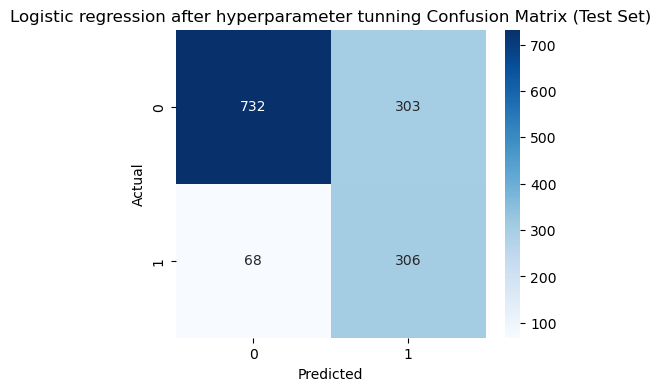


===== Logistic regression after hyperparameter tunning=====
Training Accuracy : 0.751 | ROC-AUC : 0.863
Test Accuracy     : 0.737 | ROC-AUC : 0.845
Cross-Validation Accuracy : 0.766 ± 0.008
Cross-Validation ROC-AUC  : 0.841 ± 0.009
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1035
           1       0.50      0.82      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.81      0.74      0.75      1409



In [153]:
# --- Fit on full training set ---
final_model.fit(X_train, y_train)

# --- Predictions for training and test sets ---
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

y_train_proba = final_model.predict_proba(X_train)[:,1]
y_test_proba = final_model.predict_proba(X_test)[:,1]

# --- Metrics ---
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

# --- Confusion matrix (test set) ---
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.title("Logistic regression after hyperparameter tunning Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- Print metrics ---
print("\n===== Logistic regression after hyperparameter tunning=====")
print(f"Training Accuracy : {train_acc:.3f} | ROC-AUC : {train_auc:.3f}")
print(f"Test Accuracy     : {test_acc:.3f} | ROC-AUC : {test_auc:.3f}")
print(f"Cross-Validation Accuracy : {cv_scores['test_accuracy'].mean():.3f} ± {cv_scores['test_accuracy'].std():.3f}")
print(f"Cross-Validation ROC-AUC  : {cv_scores['test_roc_auc'].mean():.3f} ± {cv_scores['test_roc_auc'].std():.3f}")
print(classification_report(y_test, y_test_pred))

In [155]:
import joblib

# Save the trained model
joblib.dump(grid_search.best_estimator_, "churn_model_cat.pkl")

['churn_model_cat.pkl']